In [1]:
from qiskit.transpiler.passes.routing.sabre_swap_v020 import SabreSwap
from qiskit.transpiler.passes.layout.sabre_layout_v020 import SabreLayout
from ulti.circuits import get_circuit_list, sort_circuits_by_depth
from ulti.coupling_maps import file_to_coupling_map
from ulti.pass_managers import generate_pass_managers, transpiled_data
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import random
random.seed(42)
import os

# Runs the experiment for SabreSwap v0.20 and SabreLayout v0.20


In [2]:
# Variables to change
#qc_name = "ghz_2-27"
qc_name = "size5_depth_1-10"

experiment_name = "sabre"
version = "20" # version for the routing pass after _v0.
lp_name = "sabre_0.20"
cp_name = "hex_7"

In [3]:
num_shots = 5
rp = SabreSwap
lp = SabreLayout
cm = file_to_coupling_map(f'coupling_maps/{cp_name}.txt')
pm = generate_pass_managers(num_shots, rp, lp, cm)


rp_name = experiment_name + "_v0." + version
qc_list = get_circuit_list([f'circuits/{qc_name}/'])
qc_list = sort_circuits_by_depth(qc_list)
# get first 26 circuits
qc_list = qc_list[:26]



csv_file_path = f'data/{qc_name}/{experiment_name}_v0{version}.csv'
directory = f'data/{qc_name}'
if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
data_list = []
for qc_idx, qc in enumerate(qc_list):
    data = transpiled_data(qc, pm)
    data['routing pass'] = rp_name
    data['layout pass'] = lp_name
    data['coupling map'] = cp_name
    data['circuit label'] = qc_idx
    data_list.append(data)

    print(f"Finished {qc_idx}")
print("Finished all")

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished all


In [5]:
df = pd.DataFrame(data_list)
df.to_csv(csv_file_path, index=False)
df

,best_data,std_dev,routing pass,layout pass,coupling map,circuit label
0,"{'depth': 1, 'depth_ratio': 1.0, 'time': 0.005...","{'depth': 1.886, 'depth_ratio': 1.886, 'time':...",sabre_v0.20,sabre_0.20,hex_7,0
1,"{'depth': 2, 'depth_ratio': 1.0, 'time': 0.010...","{'depth': 1.886, 'depth_ratio': 0.9428, 'time'...",sabre_v0.20,sabre_0.20,hex_7,1
2,"{'depth': 3, 'depth_ratio': 1.0, 'time': 0.009...","{'depth': 0, 'depth_ratio': 0, 'time': 0.01442...",sabre_v0.20,sabre_0.20,hex_7,2
3,"{'depth': 7, 'depth_ratio': 1.75, 'time': 0.01...","{'depth': 0, 'depth_ratio': 0, 'time': 0.00014...",sabre_v0.20,sabre_0.20,hex_7,3
4,"{'depth': 15, 'depth_ratio': 3.0, 'time': 0.01...","{'depth': 6.342, 'depth_ratio': 1.268, 'time':...",sabre_v0.20,sabre_0.20,hex_7,4
5,"{'depth': 12, 'depth_ratio': 2.0, 'time': 0.01...","{'depth': 0, 'depth_ratio': 0, 'time': 0.00019...",sabre_v0.20,sabre_0.20,hex_7,5
6,"{'depth': 18, 'depth_ratio': 2.57, 'time': 0.0...","{'depth': 6.182, 'depth_ratio': 0.8824, 'time'...",sabre_v0.20,sabre_0.20,hex_7,6
7,"{'depth': 22, 'depth_ratio': 2.75, 'time': 0.0...","{'depth': 5.735, 'depth_ratio': 0.7169, 'time'...",sabre_v0.20,sabre_0.20,hex_7,7
8,"{'depth': 20, 'depth_ratio': 2.22, 'time': 0.0...","{'depth': 0.4714, 'depth_ratio': 0.05185, 'tim...",sabre_v0.20,sabre_0.20,hex_7,8


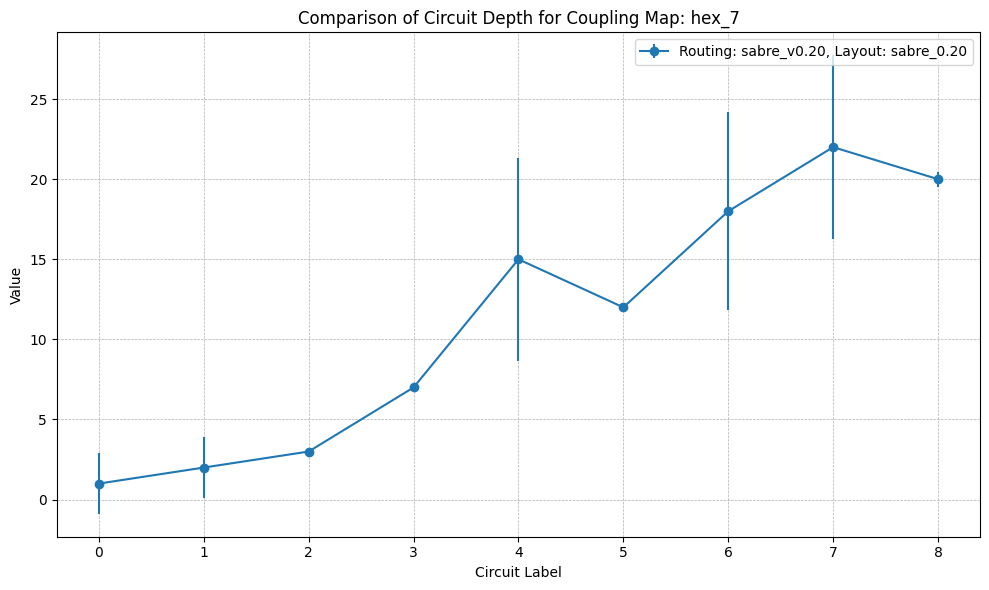

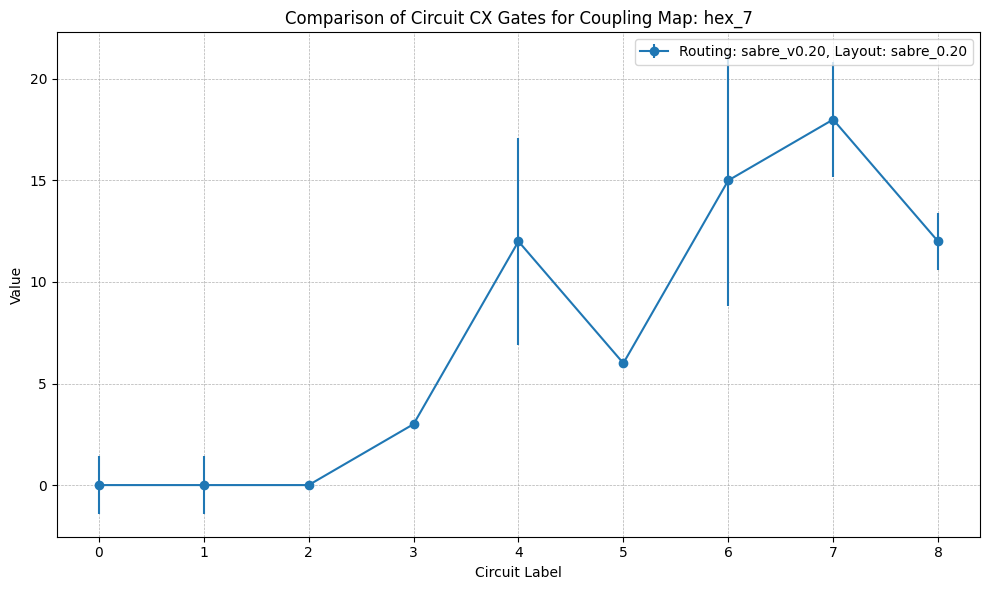

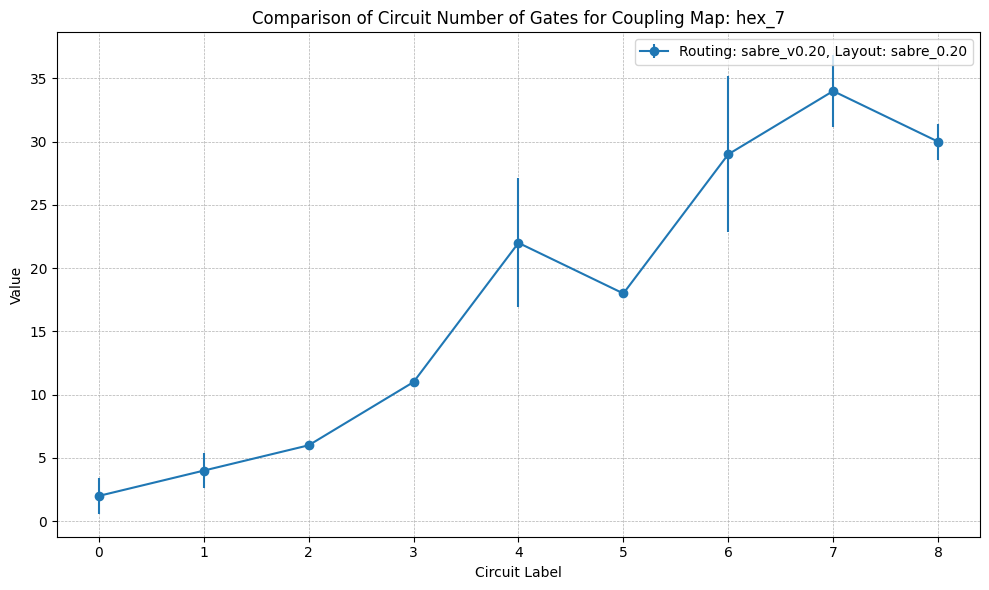

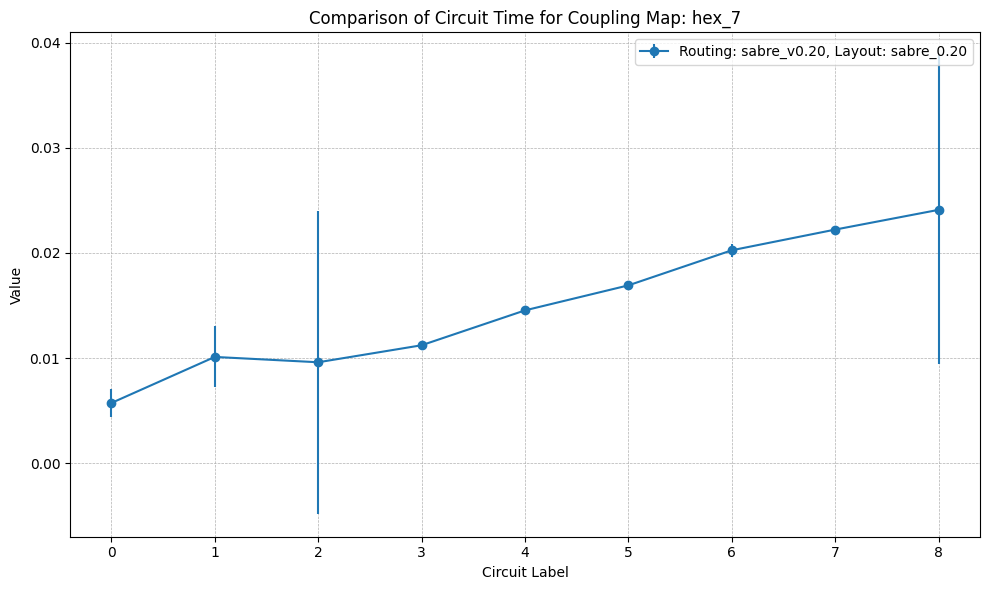

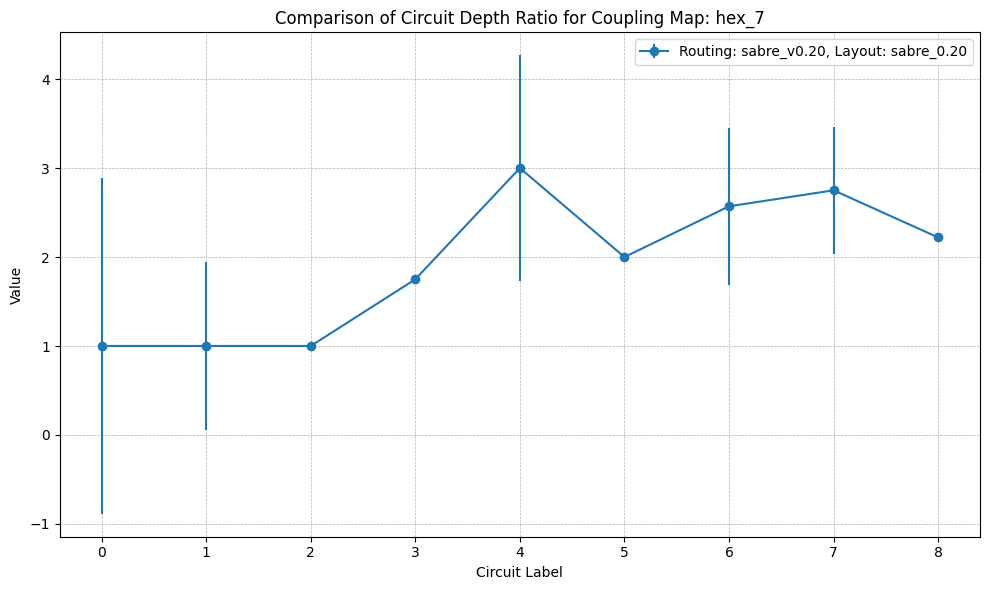

In [6]:
data = pd.read_csv(csv_file_path)

# Convert the string representation of dictionaries into actual dictionaries
data['best_data'] = data['best_data'].apply(literal_eval)
data['std_dev'] = data['std_dev'].apply(literal_eval)

# Extract the data from the 'best_data' and 'std_dev' columns and add them to the DataFrame
for col in ['depth', 'depth_ratio', 'time', 'cx_gates', 'num_gates']:
    data[f"best_{col}"] = data['best_data'].apply(lambda x: x[col])
    data[f"std_dev_{col}"] = data['std_dev'].apply(lambda x: x[col])

metrics = [
    ("depth", "Depth"),
    ("cx_gates", "CX Gates"),
    ("num_gates", "Number of Gates"),
    ("time", "Time"),
    ("depth_ratio", "Depth Ratio")
]

unique_routing_layout_combinations = data[['routing pass', 'layout pass']].drop_duplicates().values

for metric, label in metrics:
    plt.figure(figsize=(10, 6))
    for routing_pass, layout_pass in unique_routing_layout_combinations:
        subset = data[(data['routing pass'] == routing_pass) & (data['layout pass'] == layout_pass)]
        plt.errorbar(subset['circuit label'], subset[f"best_{metric}"], yerr=subset[f"std_dev_{metric}"], fmt='o-', label=f'Routing: {routing_pass}, Layout: {layout_pass}')
    plt.xlabel('Circuit Label')
    plt.ylabel('Value')
    plt.title(f'Comparison of Circuit {label} for Coupling Map: {data["coupling map"].iloc[0]}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    #plt.savefig(f"data/graphs/{qc_name}/{experiment_name}_v0{version}/{label.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()